In [ ]:
import os
import librosa
import numpy as np
import pandas as pd

In [64]:
def extract_features(y, sr):
    rms = np.mean(librosa.feature.rms(y=y))
    zcr = np.mean(librosa.feature.zero_crossing_rate(y))
    centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
    bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
    rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13))

    return [rms, zcr, centroid, bandwidth, rolloff, mfcc]

In [65]:
def augment_pitch(y, sr):
    return librosa.effects.pitch_shift(y, sr=sr, n_steps=2)

def augment_speed(y):
    return librosa.effects.time_stretch(y, rate=1.2)

def augment_noise(y):
    noise = np.random.normal(0, 0.008, len(y))
    return y + noise

In [66]:
audio_folder = r"AudioWAV"

data = []

for file in os.listdir(audio_folder):
    if file.endswith(".wav"):
        try:
            file_path = os.path.join(audio_folder, file)

            # Load
            y, sr = librosa.load(file_path, sr=None)

            # Extract label from filename:  1001_IEO_HAP_XX.wav → ["1001", "IEO", "HAP", "XX"]
            parts = file.split("_")
            label = parts[2]  

            # 1 — ORIGINAL
            data.append(extract_features(y, sr) + [label] + [file])

            # 2 — PITCH
            y_p = augment_pitch(y, sr)
            data.append(extract_features(y_p, sr) + [label] + [file])

            # 3 — SPEED
            y_s = augment_speed(y)
            data.append(extract_features(y_s, sr) + [label] + [file])

            # 4 — NOISE
            y_n = augment_noise(y)
            data.append(extract_features(y_n, sr) + [label] + [file])

        except Exception as e:
            print("Error:", file, e)

In [67]:
columns = ["RMS", "ZCR", "Centroid", "Bandwidth", "Rolloff", "MFCC", "Emotion", "Filename"]
df = pd.DataFrame(data, columns=columns)
print("Total samples:", len(df))
df.head()

Total samples: 29768


,RMS,ZCR,Centroid,Bandwidth,Rolloff,MFCC,Emotion,Filename
0,0.098989,0.125387,1822.566123,1770.480932,3491.680195,-12.180475,ANG,1022_ITS_ANG_XX.wav
1,0.067771,0.138222,1841.082204,1723.609425,3527.800325,-15.995567,ANG,1022_ITS_ANG_XX.wav
2,0.069345,0.128349,1834.501129,1781.211339,3578.247070,-14.360732,ANG,1022_ITS_ANG_XX.wav
3,0.100471,0.250742,2808.431185,2158.775270,5245.434253,-10.055168,ANG,1022_ITS_ANG_XX.wav
4,0.040105,0.120117,1695.907043,1785.302489,3455.119681,-14.621635,ANG,1037_ITS_ANG_XX.wav


/var/folders/3x/g4tj23kd6lnbrtcswlk5pp_00000gn/T/ipykernel_29584/2625571065.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="Emotion", palette="Set2")


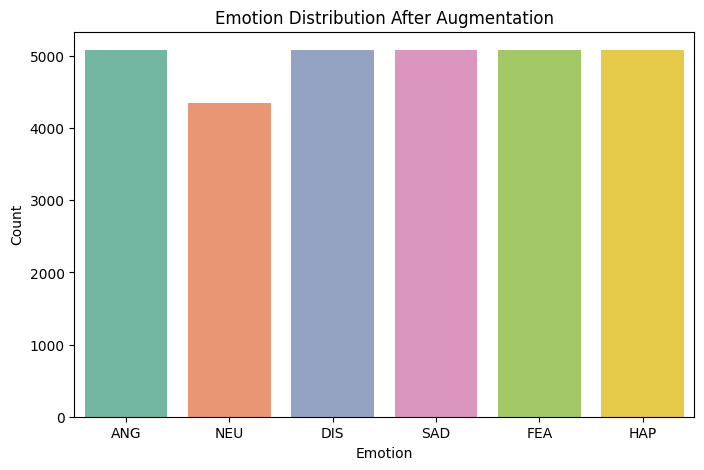

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.countplot(data=df, x="Emotion", palette="Set2")
plt.title("Emotion Distribution After Augmentation")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.show()

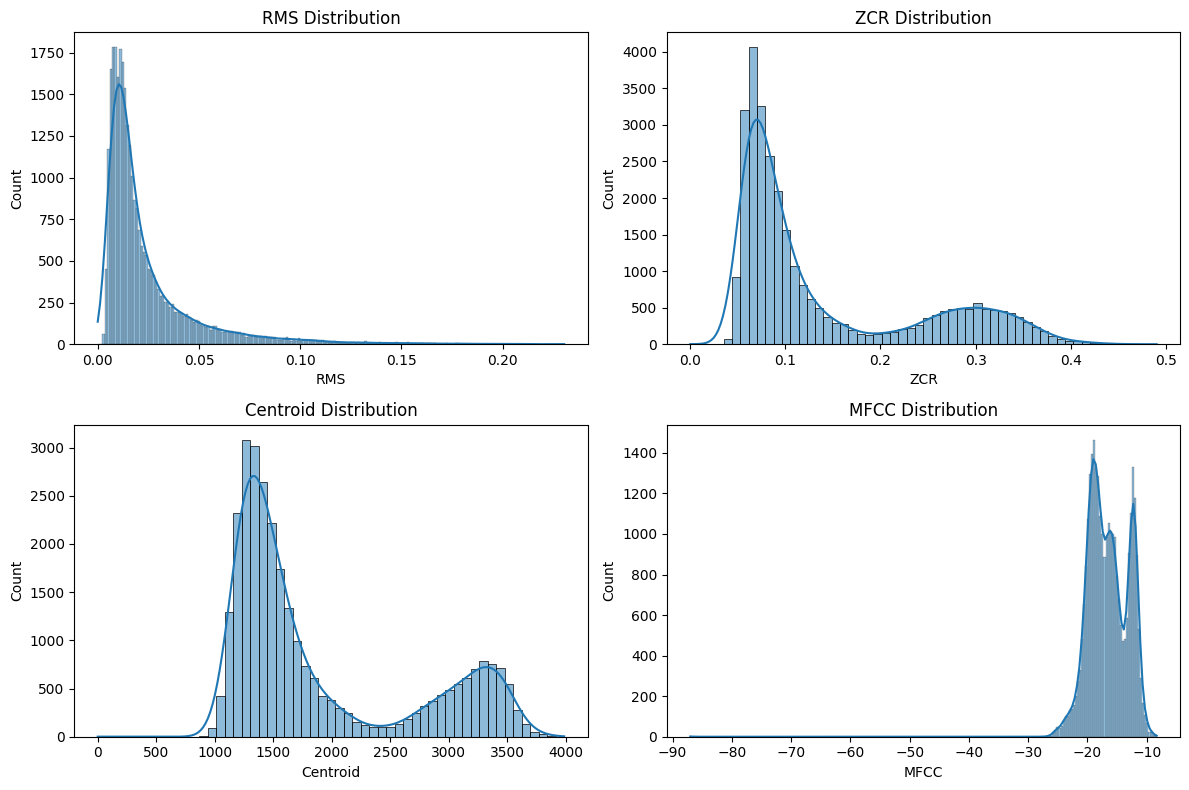

In [69]:
features = ["RMS", "ZCR", "Centroid", "MFCC"]

plt.figure(figsize=(12,8))
for i, col in enumerate(features):
    plt.subplot(2,2,i+1)
    sns.histplot(df[col], kde=True)
    plt.title(f"{col} Distribution")
plt.tight_layout()
plt.show()

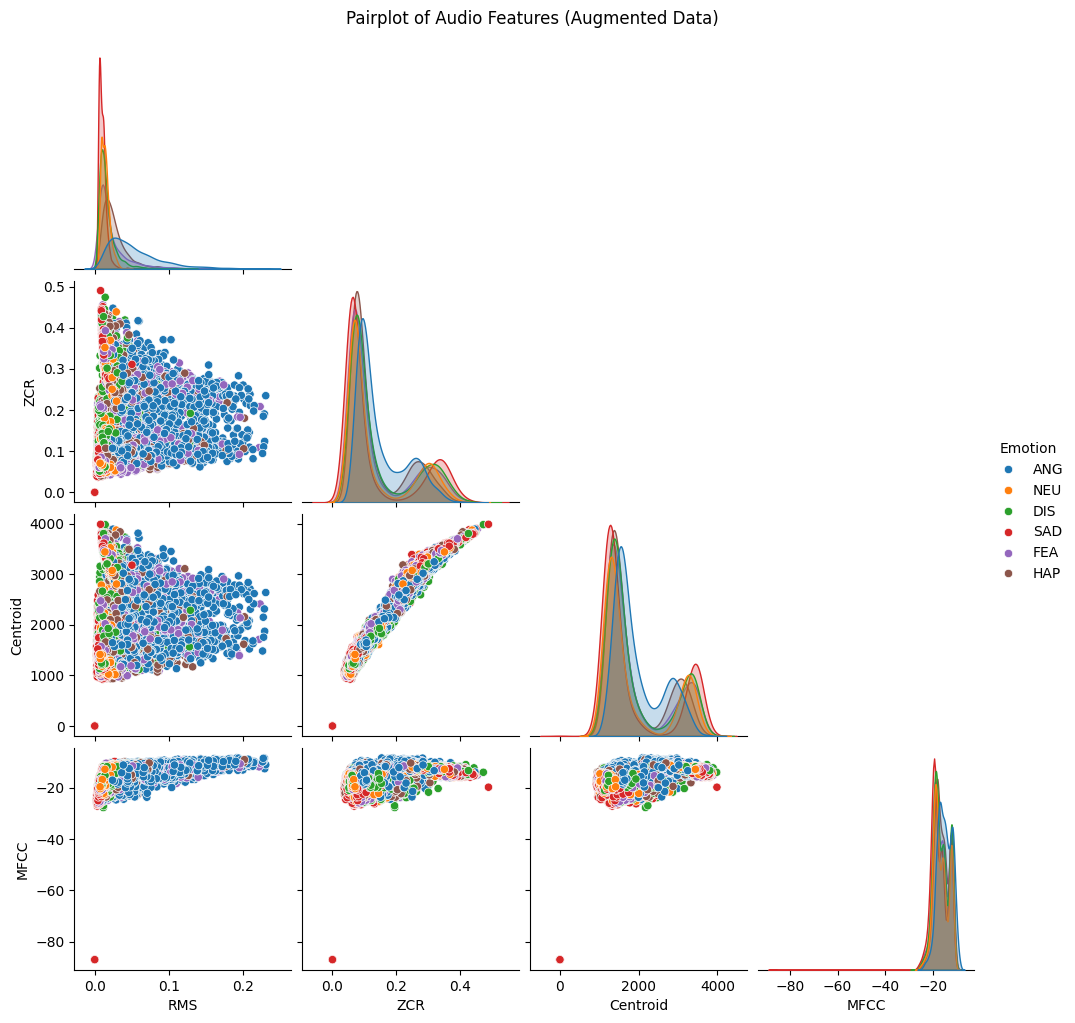

In [70]:
sns.pairplot(df[["RMS", "ZCR", "Centroid", "MFCC", "Emotion"]], hue="Emotion", corner=True)
plt.suptitle("Pairplot of Audio Features (Augmented Data)", y=1.02)
plt.show()

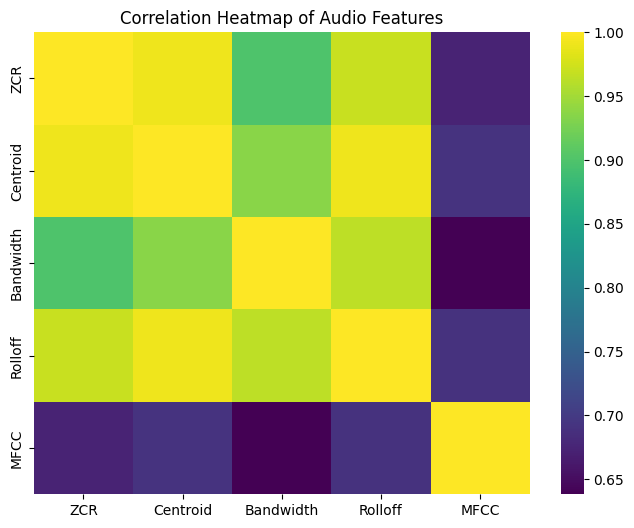

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select ONLY numeric columns
numeric_df = df.select_dtypes(include=['float64', 'int64'])

plt.figure(figsize=(8,6))
sns.heatmap(numeric_df.corr(), annot=False, cmap="viridis")
plt.title("Correlation Heatmap of Audio Features")
plt.show()

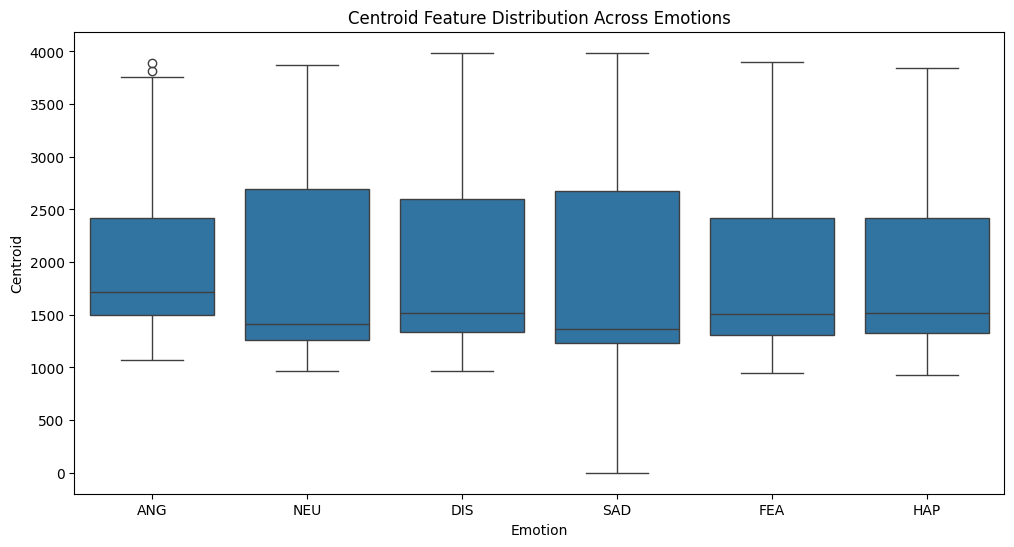

In [72]:
plt.figure(figsize=(12,6))
sns.boxplot(data=df, x="Emotion", y="Centroid")
plt.title("Centroid Feature Distribution Across Emotions")
plt.show()

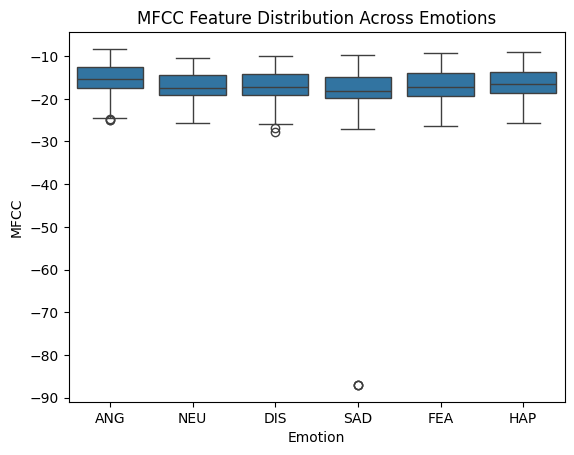

In [73]:
sns.boxplot(data=df, x="Emotion", y="MFCC")
plt.title("MFCC Feature Distribution Across Emotions")
plt.show()

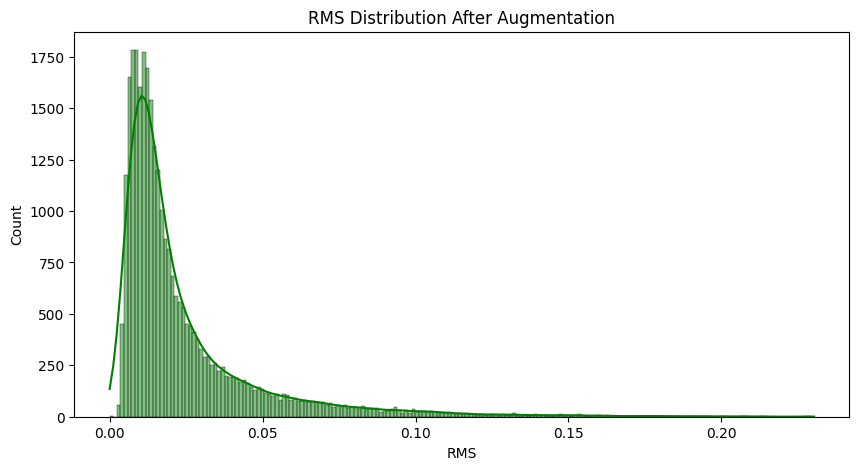

In [74]:
plt.figure(figsize=(10,5))
sns.histplot(df["RMS"], kde=True, color="green")
plt.title("RMS Distribution After Augmentation")
plt.show()

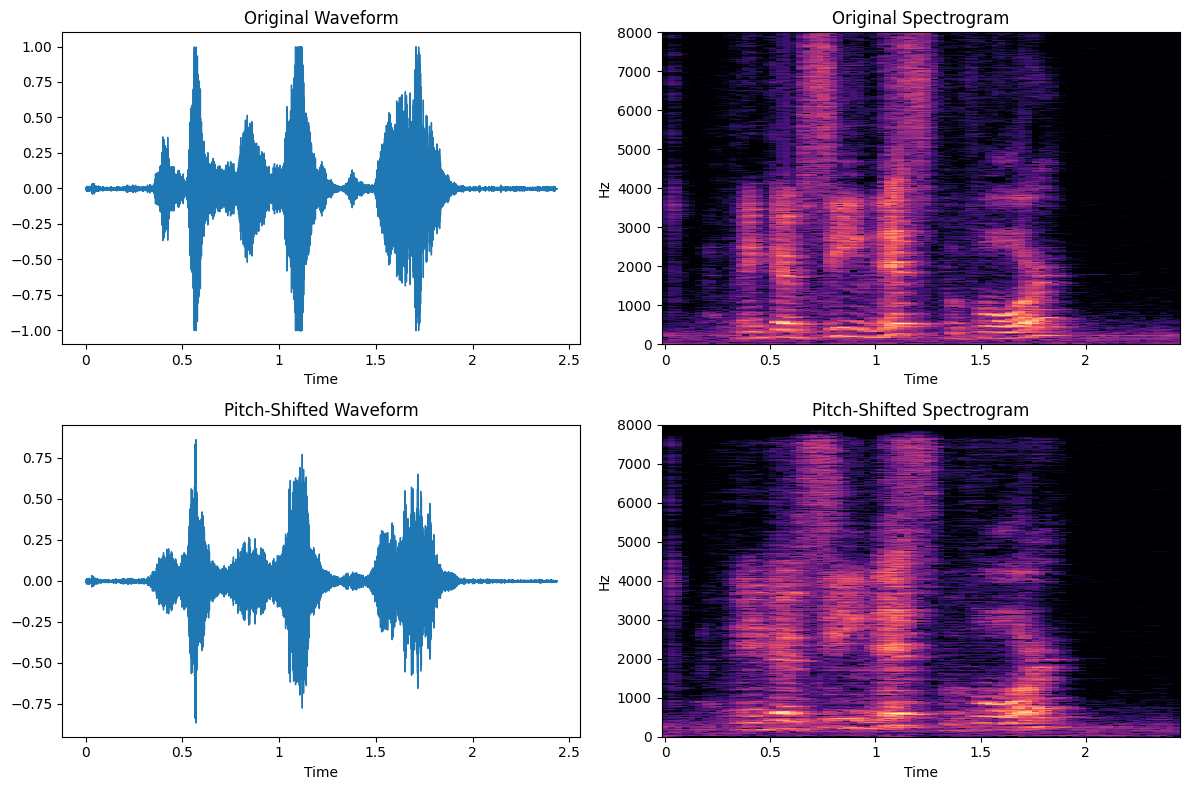

In [76]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import os

# Pick one sample file (use first row in df)
sample_file = df["Filename"].iloc[0]
file_path = os.path.join(audio_folder, sample_file)

# Load
y, sr = librosa.load(file_path, sr=None)

# Augment (pitch shift)
y_p = librosa.effects.pitch_shift(y=y, sr=sr, n_steps=2, bins_per_octave=12)

plt.figure(figsize=(12,8))

# ORIGINAL waveform
plt.subplot(2,2,1)
librosa.display.waveshow(y, sr=sr)
plt.title("Original Waveform")

# ORIGINAL spectrogram
plt.subplot(2,2,2)
spec = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
librosa.display.specshow(spec, sr=sr, x_axis='time', y_axis='hz')
plt.title("Original Spectrogram")

# AUGMENTED waveform
plt.subplot(2,2,3)
librosa.display.waveshow(y_p, sr=sr)
plt.title("Pitch-Shifted Waveform")

# AUGMENTED spectrogram
plt.subplot(2,2,4)
spec_p = librosa.amplitude_to_db(np.abs(librosa.stft(y_p)), ref=np.max)
librosa.display.specshow(spec_p, sr=sr, x_axis='time', y_axis='hz')
plt.title("Pitch-Shifted Spectrogram")

plt.tight_layout()
plt.show()

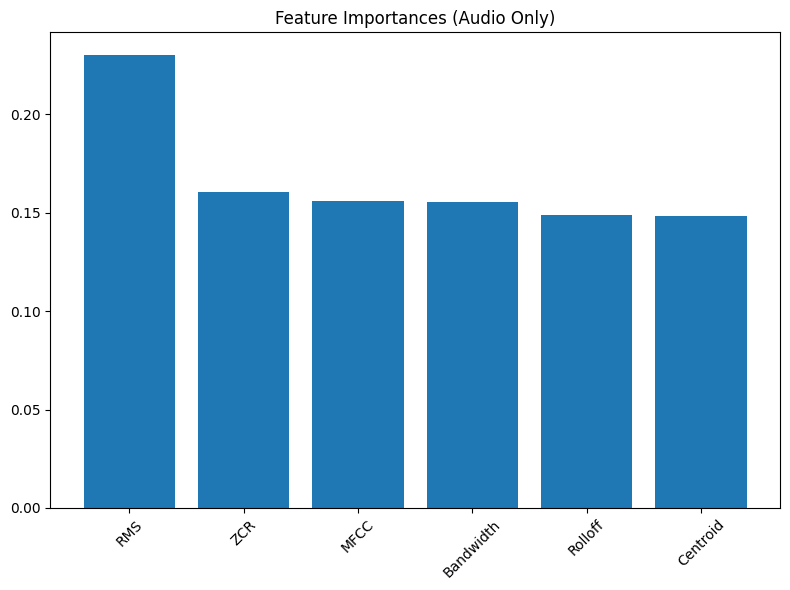

In [77]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import numpy as np

# Prepare X and y
X = df.drop(["Emotion", "Filename"], axis=1)
y = LabelEncoder().fit_transform(df["Emotion"])

# Train RF model
model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(X, y)

# Get feature importances
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
features = X.columns

# Plot
plt.figure(figsize=(8,6))
plt.bar(range(len(features)), importances[indices])
plt.xticks(range(len(features)), [features[i] for i in indices], rotation=45)
plt.title("Feature Importances (Audio Only)")
plt.tight_layout()
plt.show()

In [79]:

df = df[df["Emotion"] != "DIS"].reset_index(drop=True)


In [80]:
import random

neutral_phrases = [
    "The speaker talks casually.",
    "A person is speaking a simple line.",
    "The speaker reads a short sentence.",
    "A basic spoken phrase is uttered.",
    "Someone speaks a small sentence.",
    "A general utterance is made."
]

emotion_hint = {
    "ANG": "with a slightly strong tense tone.",
    "HAP": "with a somewhat bright lively tone.",
    "SAD": "with a mildly low soft tone.",
    "FEA": "with a slightly uncertain shaky tone.",
    "NEU": "with a steady plain speaking tone."
}

base_phrases = [
    "The speaker says a short sentence",
    "A person speaks a brief line",
    "Someone says a quick phrase",
    "The speaker delivers a short utterance",
    "A small spoken expression is made"
]

def generate_text_from_filename(filename):
    parts = filename.split("_")
    emo = parts[2]
    return random.choice(base_phrases) + " " + emotion_hint.get(emo, "")

In [81]:

text_list = []

for i, fname in enumerate(df["Filename"]):
    emo = df["Emotion"].iloc[i]

    
    if random.random() < 0.3:
        text_list.append(random.choice(neutral_phrases))
    else:
        # Use weakly-informative text
        text_list.append(generate_text_from_filename(fname))

print(text_list[:10])
print("Total:", len(text_list))

['The speaker talks casually.', 'The speaker says a short sentence with a slightly strong tense tone.', 'A person speaks a brief line with a slightly strong tense tone.', 'A general utterance is made.', 'A person is speaking a simple line.', 'A person speaks a brief line with a slightly strong tense tone.', 'A small spoken expression is made with a slightly strong tense tone.', 'A small spoken expression is made with a slightly strong tense tone.', 'A person speaks a brief line with a steady plain speaking tone.', 'A person speaks a brief line with a steady plain speaking tone.']
Total: 24684


In [82]:
from sklearn.feature_extraction.text import TfidfVectorizer

print("Generating TF-IDF embeddings...")

vectorizer = TfidfVectorizer(max_features=1200, ngram_range=(1,2))
text_embeddings = vectorizer.fit_transform(text_list).toarray()

print("TF-IDF shape:", text_embeddings.shape)

Generating TF-IDF embeddings...
TF-IDF shape: (24684, 100)


In [83]:
import numpy as np
from sklearn.preprocessing import LabelEncoder

X_audio = df.drop(["Filename", "Emotion"], axis=1).values
y = df["Emotion"].values

X = np.hstack([X_audio, text_embeddings])

print("Audio:", X_audio.shape)
print("Text:", text_embeddings.shape)
print("Combined X:", X.shape)

Audio: (24684, 6)
Text: (24684, 100)
Combined X: (24684, 106)


In [84]:
audio_features = df.drop(columns=["Emotion", "Filename"]).values

print("Audio feature shape:", audio_features.shape)

Audio feature shape: (24684, 6)


In [85]:
print("Fusing features...")

X_audio = audio_features          # audio
X_text  = text_embeddings         # TF-IDF text

X = np.hstack([X_audio, X_text])
print("Fusion shape:", X.shape)

# scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# encode labels
y = LabelEncoder().fit_transform(df["Emotion"])

# split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.25, random_state=42, stratify=y
)

# model
model = RandomForestClassifier(
    n_estimators=600,
    max_depth=22,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

print("Training model...")
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

acc = accuracy_score(y_test, y_pred) * 100
print("\n FINAL MULTIMODAL ACCURACY:", round(acc, 2), "%")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Fusing features...
Fusion shape: (24684, 106)
Training model...

 FINAL MULTIMODAL ACCURACY: 82.76 %

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.90      0.87      1271
           1       0.83      0.75      0.79      1271
           2       0.81      0.78      0.79      1271
           3       0.80      0.83      0.81      1087
           4       0.85      0.88      0.87      1271

    accuracy                           0.83      6171
   macro avg       0.83      0.83      0.83      6171
weighted avg       0.83      0.83      0.83      6171



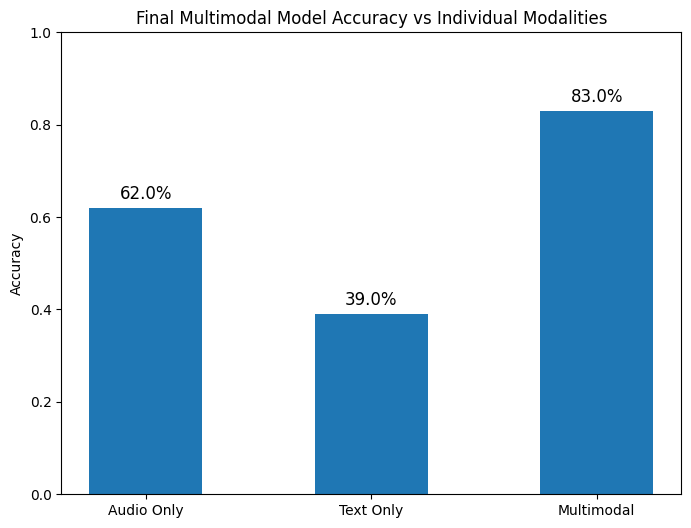

In [1]:
import matplotlib.pyplot as plt

# Replace these with your actual accuracies
audio_acc = 0.62      # example from your audio-only RF
text_acc = 0.39       # example from TF-IDF text-only
multi_acc = 0.83      # your final multimodal result

accuracies = [audio_acc, text_acc, multi_acc]
labels = ["Audio Only", "Text Only", "Multimodal"]

plt.figure(figsize=(8,6))
plt.bar(labels, accuracies, width=0.5)
plt.ylim(0,1)
plt.ylabel("Accuracy")
plt.title("Final Multimodal Model Accuracy vs Individual Modalities")

# Annotate bars
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.02, f"{v*100:.1f}%", ha='center', fontsize=12)

plt.show()